In [114]:
import numpy as np
import matplotlib.pyplot as plt

from qiskit.visualization import *
from qiskit import * 
import qiskit.quantum_info as qi
from qiskit.extensions import Initialize
from qiskit.providers.aer import extensions  # import aer snapshot instructions


import cmath
import math

import scipy.stats as stats
import qutip


import time, datetime
import pandas as pd
import os.path

# Generating the Fermionic Hamiltonian 

In [127]:
from qiskit_nature.drivers import UnitsType, Molecule
from qiskit_nature.drivers.second_quantization import ElectronicStructureDriverType, ElectronicStructureMoleculeDriver
from qiskit_nature.problems.second_quantization import ElectronicStructureProblem
from qiskit_nature.mappers.second_quantization import ParityMapper, JordanWignerMapper, BravyiKitaevMapper
from qiskit_nature.converters.second_quantization import QubitConverter
from qiskit_nature.transformers.second_quantization.electronic import ActiveSpaceTransformer, FreezeCoreTransformer
from qiskit_nature.operators.second_quantization import FermionicOp
from qiskit.opflow import StateFn, PauliExpectation,  CircuitSampler, PauliTrotterEvolution
from functools import partial 

In [12]:
from qiskit_nature.properties.second_quantization.electronic import (
    ElectronicEnergy,
    ElectronicDipoleMoment,
    ParticleNumber,
    AngularMomentum,
    Magnetization,
)

In [11]:
from qiskit_nature.properties.second_quantization.electronic.integrals import (
    ElectronicIntegrals,
    OneBodyElectronicIntegrals,
    TwoBodyElectronicIntegrals,
    IntegralProperty,
)
from qiskit_nature.properties.second_quantization.electronic.bases import ElectronicBasis

In [32]:
def get_particle_number(problem, show=True):
    particle_number = problem.grouped_property_transformed.get_property("ParticleNumber")
    num_particles = (particle_number.num_alpha, particle_number.num_beta)
    num_spin_orbitals = particle_number.num_spin_orbitals
    if show:
        print("Number of alpha electrons: {}".format(particle_number.num_alpha))
        print("Number of beta electrons: {}".format(particle_number.num_beta))
        print("Number of spin orbitals: {}".format(num_spin_orbitals))

    return particle_number

In [34]:
def get_electronic_energy(problem, show=True):
    electronic_energy = problem.grouped_property_transformed.get_property("ElectronicEnergy")
    if show:
        print(electronic_energy)
    return electronic_energy

In [167]:
#Testing for H2

# hydrogen_molecule = Molecule(geometry=[['H', [0., 0., 0.]],
#                               ['H', [0., 0., 0.735]]],
#                      charge=0, multiplicity=1)

# driver = ElectronicStructureMoleculeDriver(hydrogen_molecule, basis='sto3g', driver_type=ElectronicStructureDriverType.PYSCF)

# qH2 = driver.run()

# H2_fermionic_hamiltonian = ElectronicStructureProblem(driver)

# H2_second_q_op = H2_fermionic_hamiltonian.second_q_ops()

In [168]:
# #Testing for H2

# print("Hydrogen molecule, basis: sto3g, Hartree-Fock calculation")
# H2_particle_number = get_particle_number(H2_fermionic_hamiltonian)

# H2_electronic_energy = get_electronic_energy(H2_fermionic_hamiltonian)


# # Set truncation to None
# H2_second_q_op[0].set_truncation(0)
# # Print the Fermionic operator
# print("Hydrogen molecule Second Quantized Hamiltonian Operator")
# print(H2_second_q_op[0])
# print("Hydrogen molecule Hamiltonian Matrix")
# print(H2_second_q_op[0].to_matrix())

In [163]:
LiH_molecule = Molecule(geometry=[['Li', [0., 0., 0.]],
                              ['H', [0., 0., 1.5474]]],
                     charge=0, multiplicity=1)

driver = ElectronicStructureMoleculeDriver(LiH_molecule, basis='sto3g', driver_type=ElectronicStructureDriverType.PYSCF)

LiH_fermionic_hamiltonian = ElectronicStructureProblem(driver, transformers=[FreezeCoreTransformer(freeze_core=True, remove_orbitals=[4, 3])])

LiH_second_q_op = LiH_fermionic_hamiltonian.second_q_ops()

In [169]:
print("Lithium hydride molecule, basis: sto3g, Hartree-Fock calculation")
print("Parameters freeze_core=True, remove_orbitals=[4, 3]")
LiH_particle_number = get_particle_number(LiH_fermionic_hamiltonian)

LiH_electronic_energy = get_electronic_energy(LiH_fermionic_hamiltonian)

# Set truncation to 1000
LiH_second_q_op[0].set_truncation(1000)
# Print the Fermionic operator
print("Lithium hydride molecule 2nd Quantized Hamiltonian Operator")
print(LiH_second_q_op[0])

Lithium hydride molecule, basis: sto3g, Hartree-Fock calculation
Parameters freeze_core=True, remove_orbitals=[4, 3]
Number of alpha electrons: 1
Number of beta electrons: 1
Number of spin orbitals: 6
ElectronicEnergy
	(AO) 1-Body Terms:
		Alpha
		<(6, 6) matrix with 18 non-zero entries>
		[0, 0] = -3.0783103203371405
		[0, 1] = -0.8147472621103113
		[0, 4] = -0.015760169051754473
		[0, 5] = -0.26470827042651623
		[1, 0] = -0.8147472621103113
		... skipping 13 entries
		Beta
		<(6, 6) matrix with 18 non-zero entries>
		[0, 0] = -3.0783103203371405
		[0, 1] = -0.8147472621103113
		[0, 4] = -0.015760169051754473
		[0, 5] = -0.26470827042651623
		[1, 0] = -0.8147472621103113
		... skipping 13 entries
	(AO) 2-Body Terms:
		Alpha-Alpha
		<(6, 6, 6, 6) matrix with 368 non-zero entries>
		[0, 0, 0, 0] = 1.6803951695337487
		[0, 0, 0, 1] = 0.26542036460780716
		[0, 0, 0, 5] = 0.07982930717333647
		[0, 0, 1, 0] = 0.26542036460780705
		[0, 0, 1, 1] = 0.3977268610897301
		... skipping 363 entries

# Generating Qubit Hamiltonian with Qiskit Nature for Different Types of Mapping


In [43]:
def fermion_to_qubit(f_op, second_q_op, mapper, truncate=20, two_qubit_reduction=False, z2symmetry_reduction=None, show=True): 
    if show:        
        print("Qubit Hamiltonian operator")
        dmap = {"Jordan-Wigner": JordanWignerMapper(), "Parity": ParityMapper(), "Bravyi-Kitaev": BravyiKitaevMapper()}
        qubit_op = None
        qubit_converter = None
    for k, v in dmap.items():        
        if k == mapper:
            if show:
                print("{} transformation ". format(mapper))
                qubit_converter = QubitConverter(v, two_qubit_reduction=two_qubit_reduction, z2symmetry_reduction=z2symmetry_reduction)
            if two_qubit_reduction:
                qubit_op = qubit_converter.convert(second_q_op[0], num_particles=f_op.num_particles)
            else:
                qubit_op = qubit_converter.convert(second_q_op[0])
            n_items = len(qubit_op)
            if show:
                print("Number of items in the Pauli list:", n_items)
                if n_items <= truncate:
                    print(qubit_op)
                else:
                    print(qubit_op[0:truncate])
    return qubit_op, qubit_converter

In [172]:
print("Lithium Hydride molecule")
LiH_qubit_op, qubit_converter = fermion_to_qubit(LiH_fermionic_hamiltonian, LiH_second_q_op, "Jordan-Wigner", two_qubit_reduction=True)

Lithium Hydride molecule
Qubit Hamiltonian operator
Jordan-Wigner transformation 
Number of items in the Pauli list: 118
-0.2031660615055924 * IIIIII
- 0.03890740495187604 * IIIIIZ
+ 0.00011828807024913228 * IIIIYY
+ 0.00011828807024913228 * IIIIXX
- 0.005701661059983976 * IIIYZY
- 0.005701661059983976 * IIIXZX
- 0.12878342110289465 * IIIIZI
+ 0.015109234020498163 * IIIYYI
+ 0.015109234020498163 * IIIXXI
- 0.3121093909193637 * IIIZII
- 0.03890740495187602 * IIZIII
+ 0.00011828807024913271 * IYYIII
+ 0.00011828807024913271 * IXXIII
- 0.00570166105998397 * YZYIII
- 0.00570166105998397 * XZXIII
- 0.12878342110289462 * IZIIII
+ 0.01510923402049816 * YYIIII
+ 0.01510923402049816 * XXIIII
- 0.3121093909193637 * ZIIIII
+ 0.053149299296670595 * IIIIZZ


In [173]:
# print("Lithium Hydride molecule")
# LiH_qubit_op, qubit_converter = fermion_to_qubit(LiH_fermionic_hamiltonian, LiH_second_q_op, "Bravyi-Kitaev", two_qubit_reduction=True)

In [174]:
print("Lithium Hydride molecule")
LiH_qubit_op, qubit_converter = fermion_to_qubit(LiH_fermionic_hamiltonian, LiH_second_q_op, "Parity", two_qubit_reduction=True)

Lithium Hydride molecule
Qubit Hamiltonian operator
Parity transformation 
Number of items in the Pauli list: 100
-0.20316606150559235 * IIII
- 0.09275994933497159 * IIIZ
- 0.0029411410872802763 * IIZX
+ 0.0029411410872802763 * IIIX
- 0.0007427996395062211 * IIXX
+ 0.0007427996395062753 * IIYY
- 0.21188984297009328 * IIZZ
+ 0.01938940858370615 * IIXZ
+ 0.019389408583706205 * IIXI
+ 0.3652586902160326 * IIZI
+ 0.09275994933497192 * IZII
+ 0.002941141087280305 * ZXII
+ 0.002941141087280292 * IXII
- 0.0007427996395062432 * XXII
+ 0.0007427996395062437 * YYII
- 0.21188984297009364 * ZZII
- 0.01938940858370628 * XZII
+ 0.019389408583706226 * XIII
- 0.3652586902160355 * ZIII
- 0.12274244052545445 * IZIZ


In [175]:
from pyscf import gto, scf
import pyqmc.api as pyq
import h5py

In [176]:
from ase import Atoms
from ase.build import molecule
from ase.visualize import view

### Setting up the `PySCF()` function that computes the ground state energy using PySCF RHF (restricted Hartree-Fock) method and with the `OPTIMIZE` function in PyQMC which implements the real spave variational MOnte-Carlo technique.

In [177]:
def run_PySCF(molecule, pyqmc=True, show=True):   
    # Reset the files
    for fname in ['mf.hdf5','optimized_wf.hdf5','vmc_data.hdf5','dmc.hdf5']:
        if os.path.isfile(fname):
            os.remove(fname)

    mol_PySCF = gto.M(atom = [" ".join(map(str, (name, *coord))) for (name, coord) in molecule.geometry])

    mf = scf.RHF(mol_PySCF)
    mf.chkfile = "mf.hdf5"

    conv, e, mo_e, mo, mo_occ = scf.hf.kernel(mf)
    if show:
        if conv:
            print("PySCF restricted HF (RHF) converged ground-state energy: {:.12f}".format(e))
        else:
            print("PySCF restricted HF (RHF) ground-state computation failed to converge")

    if pyqmc:
        
        pyq.OPTIMIZE("mf.hdf5",# Construct a Slater-Jastrow wave function from the pyscf output
          "optimized_wf.hdf5", # Store optimized parameters in this file.
          nconfig=100,         # Optimize using this many Monte Carlo samples/configurations
          max_iterations=4,    # 4 optimization steps
          verbose=False)

        with h5py.File("optimized_wf.hdf5") as f:
                                   
            iter = f['iteration']
            energy = f['energy']
            error = f['energy_error']
            l = energy.shape[0]
            e = energy[l-1]
            err = error[l-1]
            if show:                
                if err < 0.1:                    
                    print("Iteration, Energy, Error")
                    for k in iter:
                        print("{}:         {:.4f} {:.4f}".format(k, energy[k], error[k]))
                    print("PyQMC Monte Carlo converged ground-state energy: {:.12f}, error: {:.4f}".format(e, err))
                else:
                    print("PyQMC Monte Carlo failed to converge")

    return conv, e

# Setting up the VQE solver (noise free simulation):

In [214]:
from qiskit_nature.algorithms import VQEUCCFactory, GroundStateEigensolver, NumPyMinimumEigensolverFactory, BOPESSampler
from qiskit.algorithms import NumPyMinimumEigensolver, VQE, HamiltonianPhaseEstimation, PhaseEstimation
from qiskit_nature.circuit.library.initial_states import HartreeFock


numpy_solver = NumPyMinimumEigensolver()

# from qiskit.circuit.library import TwoLocal
#setting up the two local circuit (will use some other day !!)
# tl_circuit = TwoLocal(rotation_blocks = ['h', 'rx'], entanglement_blocks = 'cz', entanglement='full', reps=2, parameter_prefix = 'y')

#setting up a noise-free simulation
from qiskit.utils import QuantumInstance
quantum_instance = QuantumInstance(backend = Aer.get_backend('aer_simulator_statevector'))


# vqe_ucc_solver = VQEUCCFactory(ansatz=tl_circuit)
vqe_ucc_solver = VQEUCCFactory(quantum_instance)

In [179]:
#QPE function (has some problems for LiH)
# def run_qpe(particle_number, qubit_converter, qubit_op, n_ancillae=3, num_time_slices = 1, show=True):
#     initial_state = HartreeFock(particle_number.num_spin_orbitals, 
#                             (particle_number.num_alpha, 
#                              particle_number.num_beta), qubit_converter)

#     state_preparation = StateFn(initial_state)

#     evolution = PauliTrotterEvolution('trotter', reps=num_time_slices)

#     qpe = HamiltonianPhaseEstimation(n_ancillae, quantum_instance=quantum_instance)
#     result = qpe.estimate(qubit_op, state_preparation, evolution=evolution)

#     if show:
#         # print("\nQPE initial Hartree Fock state")
#         # display(initial_state.draw(output='mpl'))
#         eigv = result.most_likely_eigenvalue
#         print("QPE computed electronic ground state energy (Hartree): {}".format(eigv))

#     return eigv

In [180]:
# function that returns the ground state energy using  GroundStateEigensolver()
def run_vqe(name, f_op, qubit_converter, solver, show=True):    
    calc = GroundStateEigensolver(qubit_converter, solver)
    start = time.time()
    ground_state = calc.solve(f_op)
    elapsed = str(datetime.timedelta(seconds = time.time()-start))
    if show:
        print("Running the VQE using the {}".format(name))
        print("Elapsed time: {} \n".format(elapsed))
        print(ground_state)
    return ground_state

In [181]:
#function that will plot the PES
def plot_energy_landscape(energy_surface_result):
    if len(energy_surface_result.points) > 1:        
        
        plt.plot(energy_surface_result.points, energy_surface_result.energies, label="VQE Energy")
        plt.xlabel('Atomic distance (Angstrom)')
        plt.ylabel('Energy (hartree)')
        plt.legend()
        plt.show()
    else:
        print("Total Energy is: ", energy_surface_result.energies[0], "hartree")
        print("(No need to plot, only one configuration calculated.)")
    return

In [196]:
#the  main function that does all the work
def solve_ground_state(
    molecule,
    mapper ="Parity",
    num_electrons=None,
    num_molecular_orbitals=None,
    transformers=None,
    two_qubit_reduction=False,
    z2symmetry_reduction = "Auto",
    name_solver='NumPy exact solver',
    solver=NumPyMinimumEigensolver(),
    plot_bopes=False,
    perturbation_steps=np.linspace(-1, 1, 3),
    pyqmc=True,
    n_ancillae=3, 
    num_time_slices=1,
    loss=[],
    label=None,
    target=None,
    show=True
):
    

    # Defining the electronic structure molecule driver
    driver = ElectronicStructureMoleculeDriver(molecule, basis='sto3g', driver_type=ElectronicStructureDriverType.PYSCF)

    # Splitting into classical and quantum
    if num_electrons != None and num_molecular_orbitals != None:
        split = ActiveSpaceTransformer(num_electrons=num_electrons, num_molecular_orbitals=num_molecular_orbitals)
    else:
        split = None

    # Defining a fermionic Hamiltonian operator
    if split != None:
        fermionic_hamiltonian = ElectronicStructureProblem(driver, [split])
    elif transformers != None:
        fermionic_hamiltonian = ElectronicStructureProblem(driver, transformers=transformers)
    else:
        fermionic_hamiltonian = ElectronicStructureProblem(driver)

    # Use the second_q_ops() method [Qiskit_Nat_3] which returns a list of second quantized operators
    second_q_op = fermionic_hamiltonian.second_q_ops()

    # Get particle number
    particle_number = get_particle_number(fermionic_hamiltonian, show=show)

    if show:        
        # We set truncation to 1000 with the method set_truncation(1000)
        second_q_op[0].set_truncation(1000)
        # then we print the first 20 terms of the fermionic Hamiltonian operator of the molecule
        print("Fermionic Hamiltonian operator")
        print(second_q_op[0])
    
    # Use the function fermion_to_qubit() to convert a fermionic operator to a qubit operator
    if show:
        print(" ")
    qubit_op, qubit_converter = fermion_to_qubit(fermionic_hamiltonian, second_q_op, mapper=mapper, two_qubit_reduction=two_qubit_reduction, z2symmetry_reduction=z2symmetry_reduction, show=show)

    # Run the the PySCF RHF method
    if show:
        print(" ")
    conv, e = run_PySCF(molecule, pyqmc=pyqmc, show=show)

    # # Run QPE
    # eigv = run_qpe(particle_number, qubit_converter, qubit_op, n_ancillae=n_ancillae, num_time_slices=num_time_slices, show=show)

    # Run VQE
    if show:
        print(" ")
    ground_state = run_vqe(name_solver, fermionic_hamiltonian, qubit_converter, solver, show=show)

    # # Plot loss function
    # if loss != []:
    #   plot_loss(loss, label, target)

    if plot_bopes:        
        # Compute the potential energy surface as follows:
        energy_surface = BOPESSampler(gss=GroundStateEigensolver(qubit_converter, solver), bootstrap=False)
        # Fix enables using BOPESS together with Unitary Coupled Cluster (UCC) factory ansatz
        # Set default to an empty dictionary instead of None:
        energy_surface._points_optparams = {}
        energy_surface_result = energy_surface.sample(fermionic_hamiltonian, perturbation_steps)

        # Plot the energy as a function of atomic separation
        plot_energy_landscape(energy_surface_result)

    return fermionic_hamiltonian, particle_number, qubit_op, qubit_converter, ground_state, energy_surface_result.points, energy_surface_result.energies

# Checking the Code for H2 using UCC

In [197]:
hydrogen_molecule = Molecule(geometry=[['H', [0., 0., 0.]],
                              ['H', [0., 0., 0.3]]],
                     charge=0, multiplicity=1)

In [198]:
specific_molecular_variation = partial(Molecule.absolute_distance, atom_pair=(1, 0))

In [199]:
hydrogen_molecule_stretchable = Molecule(geometry=
                                 [['H', [0., 0., 0.]],
                                  ['H', [0., 0., 0.3]]],
                                  charge=0, multiplicity=1,
                                  degrees_of_freedom=[specific_molecular_variation])

In [200]:
# H2_fermionic_hamiltonian, H2_particle_number, H2_qubit_op, H2_qubit_converter, H2_ground_state = \
#                   solve_ground_state(hydrogen_molecule, mapper ="Parity",
#                    two_qubit_reduction=True, z2symmetry_reduction=None, 
#                    name_solver = 'NumPy exact solver', solver = numpy_solver)

In [201]:
# H2_fermionic_hamiltonian, H2_particle_number, H2_qubit_op, H2_qubit_converter, H2_ground_state = \
#                   solve_ground_state(hydrogen_molecule, mapper ="Parity",
#                    two_qubit_reduction=True, z2symmetry_reduction=None, 
#                    name_solver = 'Unitary Coupled Cluster (UCC) factory ansatz', solver = vqe_ucc_solver)

Number of alpha electrons: 1
Number of beta electrons: 1
Number of spin orbitals: 4
Fermionic Hamiltonian operator
Fermionic Operator
register length=4, number terms=36
  -0.7789220360818258 * ( +_0 -_0 )
+ -0.670266671828837 * ( +_1 -_1 )
+ -0.7789220360818258 * ( +_2 -_2 )
+ -0.670266671828837 * ( +_3 -_3 )
+ -0.2547314062131492 * ( +_0 +_0 -_0 -_0 )
+ -0.12956923744052842 * ( +_0 +_1 -_1 -_0 )
+ -0.1295692374405284 * ( +_0 +_0 -_1 -_1 )
+ -0.2596006290647683 * ( +_0 +_1 -_0 -_1 )
+ -0.2547314062131492 * ( +_0 +_2 -_0 -_2 )
+ -0.12956923744052842 * ( +_0 +_3 -_1 -_2 )
+ -0.1295692374405284 * ( +_0 +_2 -_1 -_3 )
+ -0.2596006290647683 * ( +_0 +_3 -_0 -_3 )
+ -0.25960062906476833 * ( +_1 +_0 -_1 -_0 )
+ -0.12956923744052845 * ( +_1 +_1 -_0 -_0 )
+ -0.1295692374405284 * ( +_1 +_0 -_0 -_1 )
+ -0.2673320597646799 * ( +_1 +_1 -_1 -_1 )
+ -0.25960062906476833 * ( +_1 +_2 -_1 -_2 )
+ -0.12956923744052845 * ( +_1 +_3 -_0 -_2 )
+ -0.1295692374405284 * ( +_1 +_2 -_0 -_3 )
+ -0.2673320597646799 *

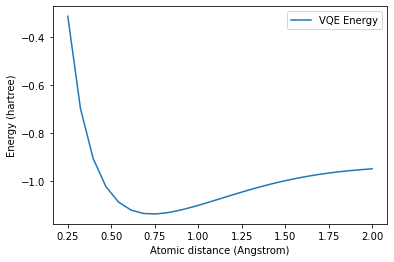

In [215]:
perturbation_steps = np.linspace(0.25, 2, 25) # 25 equally spaced points from 0.25 to 2, inclusive.
H2_stretchable_fermionic_hamiltonian, H2_stretchable_particle_number, H2_stretchable_qubit_op, H2_stretchable_qubit_converter, H2_stretchable_ground_state, H2_points, H2_energies = \
                  solve_ground_state(hydrogen_molecule_stretchable, mapper ="Parity",
                   two_qubit_reduction=True, z2symmetry_reduction=None, 
                   name_solver = 'Unitary Coupled Cluster (UCC) factory ansatz', solver = vqe_ucc_solver,
                   plot_bopes = True, perturbation_steps=perturbation_steps)

In [213]:
#print( H2_energies)

# Final Results for LiH using UCC

In [216]:
LiH_molecule = Molecule(geometry=[['Li', [0., 0., 0.]],
                              ['H', [0., 0., 1.5474]]],
                     charge=0, multiplicity=1)

In [217]:
LiH_molecule_stretchable = Molecule(geometry=[['Li', [0., 0., 0.]],
                              ['H', [0., 0., 1.5474]]],
                    charge=0, multiplicity=1,
                    degrees_of_freedom=[specific_molecular_variation])

Number of alpha electrons: 1
Number of beta electrons: 1
Number of spin orbitals: 6
Fermionic Hamiltonian operator
Fermionic Operator
register length=6, number terms=342
  -0.7806641144801778 * ( +_0 -_0 )
+ 0.0477021233845864 * ( +_0 -_1 )
+ -0.1295811889750368 * ( +_0 -_2 )
+ 0.04770212338458636 * ( +_1 -_0 )
+ -0.3590972934808564 * ( +_1 -_1 )
+ 0.06823802789333827 * ( +_1 -_2 )
+ -0.1295811889750366 * ( +_2 -_0 )
+ 0.06823802789333827 * ( +_2 -_1 )
+ -0.2261711489984197 * ( +_2 -_2 )
+ -0.7806641144801778 * ( +_3 -_3 )
+ 0.0477021233845864 * ( +_3 -_4 )
+ -0.1295811889750368 * ( +_3 -_5 )
+ 0.04770212338458636 * ( +_4 -_3 )
+ -0.3590972934808564 * ( +_4 -_4 )
+ 0.06823802789333827 * ( +_4 -_5 )
+ -0.1295811889750366 * ( +_5 -_3 )
+ 0.06823802789333827 * ( +_5 -_4 )
+ -0.2261711489984197 * ( +_5 -_5 )
+ -0.24548488105091024 * ( +_0 +_0 -_0 -_0 )
+ 0.02385105856894651 * ( +_0 +_0 -_1 -_0 )
+ -0.06479059463973484 * ( +_0 +_0 -_2 -_0 )
+ 0.023851058568946513 * ( +_0 +_1 -_0 -_0 )
+ -0.

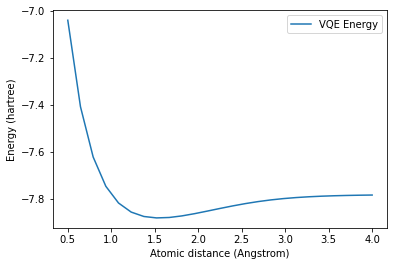

In [218]:
perturbation_steps = np.linspace(0.5, 4.0, 25) # 10 equally spaced points from -0.8 to 0.8, inclusive.
LiH_stretchable_fermionic_hamiltonian, LiH_stretchable_particle_number, LiH_stretchable_qubit_op, LiH_stretchable_qubit_converter, LiH_stretchable_ground_state, LiH_points, LiH_energies = \
                  solve_ground_state(LiH_molecule_stretchable, mapper ="Parity",
                  transformers=[FreezeCoreTransformer(freeze_core=True, remove_orbitals=[4, 3])],
                   two_qubit_reduction=True, z2symmetry_reduction="auto", 
                   name_solver='Unitary Coupled Cluster (UCC) factory ansatz', solver=vqe_ucc_solver,
                   plot_bopes=True, perturbation_steps=perturbation_steps)

In [219]:
print(LiH_energies)

[(-7.039732392739566+0j), (-7.407898915381772+0j), (-7.621870567965875+0j), (-7.746665607795318+0j), (-7.81782791625732+0j), (-7.856530741740714+0j), (-7.875217854696458+0j), (-7.8813127300018095+0j), (-7.8794644713929785+0j), (-7.8727282087827+0j), (-7.863182187519777+0j), (-7.852275500320786+0j), (-7.8410423496030806+0j), (-7.830233752120751+0j), (-7.8203832715683195+0j), (-7.811834265858669+0j), (-7.804735960646987+0j), (-7.79906481887369+0j), (-7.794668075956314+0j), (-7.791333082096125+0j), (-7.788839923373454+0j), (-7.786993872128903+0j), (-7.785636039316197+0j), (-7.784642334613119+0j), (-7.78391828949042+0j)]


# Comparing VQE results with Exact Results for LiH 

In [220]:
#using the code given to us in the repo
from utility import obtain_PES
bond_lengths = np.linspace(0.5,4.0,25)
basis = 'sto-3g'

In [221]:
#Run FCI
FCI_PES = obtain_PES('lih', bond_lengths, basis, method='fci')

E = -7.050225036066626 Eh
E = -7.412849362554086 Eh
E = -7.625120281681296 Eh
E = -7.749112772045482 Eh
E = -7.81980626891099 Eh
E = -7.858213609128353 Eh
E = -7.876698988646929 Eh
E = -7.882638926393844 Eh
E = -7.880658174777379 Eh
E = -7.873802222219945 Eh
E = -7.864146306869409 Eh
E = -7.853139891767199 Eh
E = -7.841817859376814 Eh
E = -7.830930520026347 Eh
E = -7.821012644471176 Eh
E = -7.812405819796487 Eh
E = -7.805260034839402 Eh
E = -7.799549610251223 Eh
E = -7.7951215468409485 Eh
E = -7.791761252488713 Eh
E = -7.789247873611299 Eh
E = -7.787385676957605 Eh
E = -7.786014838593346 Eh
E = -7.785010648745602 Eh
E = -7.784278178706959 Eh


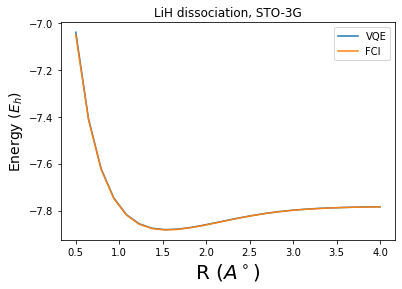

In [222]:
#Plot LiH PESs

plt.title('LiH dissociation, STO-3G')
plt.xlabel(r'R ($A^\circ$)',fontsize=20)
plt.ylabel(r'Energy ($E_h$)',fontsize=14)
plt.plot(LiH_points, LiH_energies, label='VQE')
plt.plot(bond_lengths, FCI_PES, label='FCI')

plt.legend()
plt.show()

### Note that the VQE results are very close to the exact results, and so the exact energy curve is hidden by the VQE curve.

